In [36]:
import xlrd
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#dont need standard scalar for tree based models..
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## MODELING with Random Forest Regression:
### using random forest regression and hyper parameter tuning, we explore a few scenarios with our features to see how removing one may affect the importance of another, and how the accuracy changes accordingly. We also watch out for over fitting by performing a k-fold grid search cross validation.

In [37]:
# reading in the csv
features_df = pd.read_csv('bat_features_df.csv')
features_df = features_df.set_index('Date')

In [38]:
features_df.head()

,SearchFrequency,DJI,price_btc,price_eth,sentiment,pos_count,neg_count,price_bat
Date,,,,,,,,
2017-11-16,55,23458.359375,7871.69,330.92,0.089579,14,75,0.167167
2017-11-17,75,23358.240234,7708.99,332.39,0.087821,8,59,0.160654
2017-11-18,103,23358.240234,7790.15,347.61,0.092867,5,82,0.162501
2017-11-19,65,23358.240234,8036.49,354.39,0.092423,3,78,0.161358
2017-11-20,96,23430.330078,8200.64,366.73,0.093611,7,80,0.157709


### recap on a description of the variables:
DJI: Dow Jones Index, price_btc: Closing price of bitcoin on that day.	price_eth: Closing price of ethereum on that day. sentiment: overall average sentiment score on all comments made on that day.	pos_count: all positive comments made on that day.	neg_count: representation of all negative comments made on that day.	price_bat : price of the BAT alt ethereum coin.

*transformations made on the data:* for variable "neg_count", I wanted to ensure that it properly had positive correlation when small numbers of negative comments were said on the forums, and negative correlation when large numbers of negative comments were made on the forum. what I did was I multiplied all the daily counts for negative comments by (-1)and then added the minimum to every data point so that now, all datapoints for this variable were non-zero, and the day that had the largest number of negative comments would have a value of exactly zero.


#### Graphing the data (with normalized scaling):

In [39]:
#lets normalize all our data to properly see:

a = features_df['price_btc'] - features_df['price_btc'].min()
b = features_df['price_eth'] - features_df['price_eth'].min()
c = features_df['sentiment'] - features_df['sentiment'].min()
d = features_df['DJI'] - features_df['DJI'].min()

e = features_df['pos_count'] - features_df['pos_count'].min()
f = features_df['neg_count'] - features_df['neg_count'].min()
g = features_df['price_bat'] - features_df['price_bat'].min()

#df_ultra_mega_frame
norm_btc = a/a.max()
norm_eth = b/b.max()
norm_sent = c/c.max()
norm_dji = d/d.max()

norm_pos = e/e.max()
norm_neg = f/f.max()
norm_bat = g/g.max()

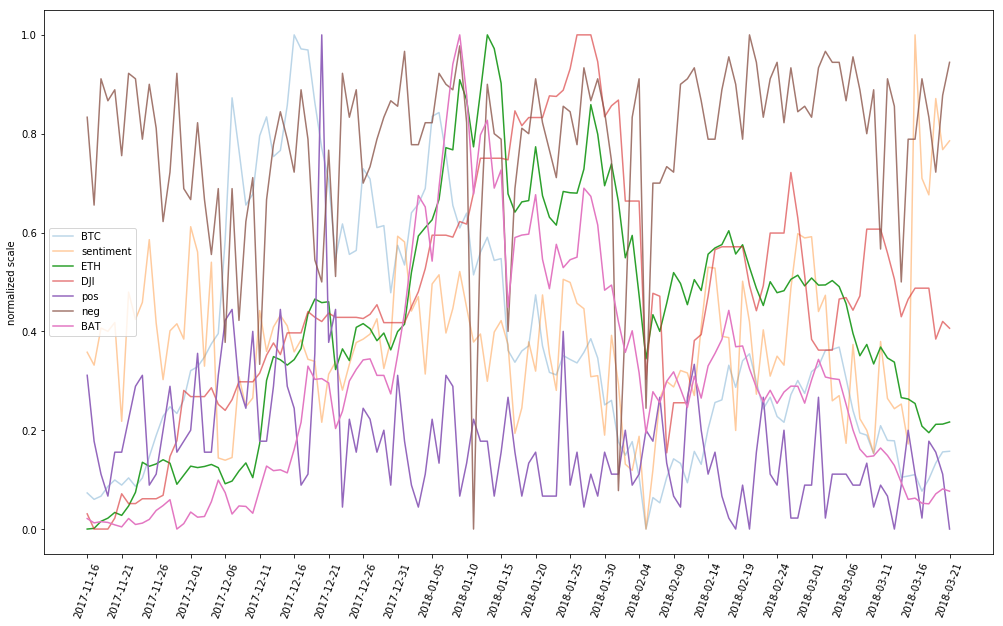

In [52]:
plt.figure(figsize=(17, 10))
line_btc = plt.plot(norm_btc, label='BTC', alpha = 0.3)
line_sent = plt.plot(norm_sent, label='sentiment', alpha = 0.4)
line_eth = plt.plot(norm_eth, label='ETH', alpha = 1)
line_dji = plt.plot(norm_dji, label='DJI', alpha = 0.6)
line_pos = plt.plot(norm_pos, label='pos', alpha = 1)
line_neg = plt.plot(norm_neg, label='neg', alpha = 0.8)
line_bat = plt.plot(norm_bat, label='BAT', alpha = 1)

plt.legend() #bbox_to_anchor=(1, 1),
 #         bbox_transform=plt.gcf().transFigure)

plt.ylabel('normalized scale')
plt.xticks(rotation=70)
plt.xticks(np.arange(0, len(features_df), 5.0))
plt.show()

#### Commentary on the graph:
It's a bit hard to see the overlaying of many features, but we can see there are deep dips in the "neg" feature when ethereum crashes, and not really a ton of spikes in "pos" feature when ethereum climbs. This *COULD* mean that negative comments have higher impact on the price than do positive comments. We could eventually investigate the shift on feature importance if we wanted to remove the postive comments and only check the impact of negative comments.

## 1) Modeling (and checking feature importance) with all the possible features 

formatting for proper input into the model . Note that for Tree-based models, the "standard scaler" from sklearn is not neccessary but in linear models it should be implemented.

In [42]:
# Remove the column name from the feature by making it an numpy array
y = np.array(features_df['price_bat'])

# axis 1 refers to the column gets dropped
features= features_df.drop(['price_bat'], axis = 1) #'pos_count','neg_count' 

# Saving feature names for later use
feature_list = list(features.columns) #this way we remeber the column names
# Convert to numpy array
X = np.array(features) #because once we convert to np array it drops the names

At this point it's a good moment to to check X.shape and y.shape to make sure our y array is one dimensional and our X array is an 'nd array' with n corresponding to the number of features.

In [43]:
print(X.shape)
print(y.shape) # y should be 1 dimensional which it is

(126, 7)
(126,)


Conducting our test train split where train is 75% and test is 25% of data

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [45]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, Y_train)

/Users/alexandraduboy/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Below we print out our feature importancce values to give us an idea of which feature is the most important to our model. Here we note that any features that go to zero would be considered to not play any role in improving our model. There are two features that are close to zero but still non-zero, so they technically are still marginally improving our model. it is also best practice to keep an eye on the curse of dimensionality when feeding a ton of variables into your model, and measures like feature importance or the concept of principal component analysis, are good ways to intelligently choose your features.

##### Feature importance:
Here we look at a graph of our feature importance

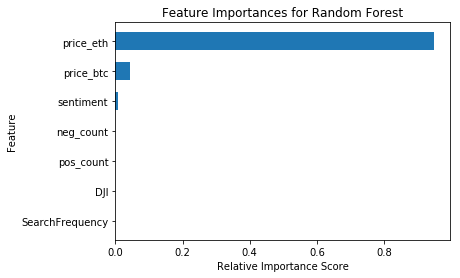

In [50]:
feat_import = regr.feature_importances_
feature_names, feature_scores = zip(*sorted(zip(feature_list, feat_import), 
                                                          key=lambda x: -x[1], reverse=True))
feature_names = feature_names[:10]
feature_scores = feature_scores[:10]
y_position = list(range(len(feature_names)))
plt.barh(y_position, feature_scores, height=0.6, align='center')
plt.yticks(y_position , feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Random Forest')
plt.show()

In [51]:
feature_names, feature_scores = zip(*sorted(zip(feature_list, feat_import), 
                                                          key=lambda x: -x[1], reverse=True))
featimp_d = {'features': feature_names, 'importances': feature_scores}
featimp_df = pd.DataFrame(data=featimp_d)
featimp_df.set_index('features')

,importances
features,
SearchFrequency,0.000000
DJI,0.000000
pos_count,0.000000
neg_count,0.000000
sentiment,0.006700
price_btc,0.044071
price_eth,0.949229


*unfortunatley* the variables pos_count and neg_count dont seem to make a contribution to the model. This was the most interesting variable to us and we wanted to explore its correlation.

### Conclusion to be made:
It looks like ETH price mattered the most for this alt coin. That makes intuitive sense because it is a derivative from ethereum. 

Although, I did find it a little surprising that Dow Jones was so highly indicative in ethereum's price and not of BAT's price, I did eventually check the feature importance after removing ethereum price (price_eth) from the feature list.

#### This is done further below in the notebook. First we will perform a grid CV search on our current features which include the ethereum price. Then our last exploration will investigate what happens when we remove positive comments, because negative comments seem to have a stronger correlation with price drop than positive comments do on price rise.

The following is previewing a sample output for Y using the prediction on X_test

In [25]:
# sample output for our predicted y (or predicted price_bat)
print(regr.predict(X_test))

[0.63127769 0.19128932 0.30617826 0.54223979 0.4226446  0.54223979
 0.30617826 0.64477724 0.28741933 0.30617826 0.19128932 0.36895379
 0.21937456 0.36895379 0.4226446  0.19128932 0.4226446  0.19128932
 0.6855553  0.19128932 0.35392002 0.19969212 0.54223979 0.19128932
 0.64477724 0.36895379 0.54223979 0.19128932 0.36895379 0.19128932
 0.30617826 0.19128932]


regr.score(X_test, Y_test) takes in parameters X_test, makes a precidtion on it (it calls .predict) and then compares with the second parameter thats fed in, being X_test.

In [28]:
#now can compare with the original X and Y_train!!!
#using score 
regr.score(X_test, Y_test) #X_test , as seen above...X_test has more dimensions than the output on predict

0.9100591971359888

So we have an accuraccy starting out at 91, one would possibly be suspicious about overfitting at first glance, but we will perform a grid CV search to cross validate. This is implemented below.

### Hyperparameter tuning: 

When using a technique like k-fold cross validation, your model evaluation for hyperparameter optimization would be the average of k model evaluations from each of the k folds of your data. Techniques like this will help ensure that the metric you optimize for correlates generalizes well to unseen data.

"criterion": can either be "mse" or "mae"  (mean squared error and mean absolute error) in documentation these help decide which direction to choose in your decision tree, which side minimizes the error, and we check against two errors

max depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. it is advisable not to go higher than 8.

n estimators is number of trees in a forest. Randomforest is hard to overfit (unlike a decision tree) so large number of trees (though advisably under 300) is ok.


In [31]:
#random forest builds multiple decision trees 
#best number of decision trees
#depth of each tree shouldnt be more than 8 levels
#go down to 8 levels(splits) but dont split it further

In [29]:
#use a grid search
param_grid = {"criterion": ["mse", "mae"], 
              # mean squared error and mean absolute error in documentation
              "max_depth": [2, 6, 8],
              "n_estimators":[50, 100, 200]
              #"min_samples_leaf": [20, 40, 100],
              #"max_leaf_nodes": [5, 20, 100, 500, 800],
              }

grid_cv_regr = GridSearchCV(regr, param_grid, cv=5)

grid_cv_regr.fit(X_train, Y_train) #features and labels

/Users/alexandraduboy/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 200], 'criterion': ['mse', 'mae'], 'max_depth': [2, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Below we output the R-squaed value output for the best performing parameters

In [30]:
print("R-Squared::{}".format(grid_cv_regr.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_regr.best_params_))

R-Squared::0.902030891969
Best Hyperparameters::
{'n_estimators': 100, 'criterion': 'mse', 'max_depth': 6}


#### dataframe of cross validation results:
All of these are the explicit metrics of our Cross Validation

In [25]:
df = pd.DataFrame(data=grid_cv_regr.cv_results_)
df.head()

/Users/alexandraduboy/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/alexandraduboy/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/alexandraduboy/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.211082,0.006642,0.866113,0.940656,mse,2,50,"{u'n_estimators': 50, u'criterion': u'mse', u'...",14,0.822886,...,0.736241,0.961461,0.848038,0.929740,0.963383,0.931389,0.032442,0.002805,0.087445,0.012123
1,0.359122,0.008899,0.867268,0.941753,mse,2,100,"{u'n_estimators': 100, u'criterion': u'mse', u...",13,0.828661,...,0.733817,0.961956,0.852404,0.930217,0.961699,0.934736,0.034646,0.002014,0.087024,0.011550
2,0.760086,0.018014,0.865759,0.942113,mse,2,200,"{u'n_estimators': 200, u'criterion': u'mse', u...",15,0.828727,...,0.729712,0.962125,0.853345,0.931492,0.959738,0.935421,0.106258,0.002427,0.087301,0.011403
3,0.165661,0.004628,0.901771,0.985322,mse,6,50,"{u'n_estimators': 50, u'criterion': u'mse', u'...",2,0.868991,...,0.749715,0.993143,0.928551,0.979595,0.980143,0.985164,0.022171,0.000212,0.087357,0.004397
4,0.312628,0.008006,0.902031,0.986644,mse,6,100,"{u'n_estimators': 100, u'criterion': u'mse', u...",1,0.870764,...,0.751903,0.993262,0.925924,0.982258,0.979949,0.986197,0.001553,0.000078,0.086294,0.003626


Printing out the best hyper parameters.

In [35]:
results = grid_cv_regr.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))    
#the highest is n=100, and mx depth 8

({'n_estimators': 50, 'criterion': 'mse', 'max_depth': 2}, 0.8661, 0.0874)
({'n_estimators': 100, 'criterion': 'mse', 'max_depth': 2}, 0.8673, 0.087)
({'n_estimators': 200, 'criterion': 'mse', 'max_depth': 2}, 0.8658, 0.0873)
({'n_estimators': 50, 'criterion': 'mse', 'max_depth': 6}, 0.9018, 0.0874)
({'n_estimators': 100, 'criterion': 'mse', 'max_depth': 6}, 0.902, 0.0863)
({'n_estimators': 200, 'criterion': 'mse', 'max_depth': 6}, 0.8987, 0.087)
({'n_estimators': 50, 'criterion': 'mse', 'max_depth': 8}, 0.9002, 0.0871)
({'n_estimators': 100, 'criterion': 'mse', 'max_depth': 8}, 0.8989, 0.0875)
({'n_estimators': 200, 'criterion': 'mse', 'max_depth': 8}, 0.8972, 0.0871)
({'n_estimators': 50, 'criterion': 'mae', 'max_depth': 2}, 0.8594, 0.0943)
({'n_estimators': 100, 'criterion': 'mae', 'max_depth': 2}, 0.8563, 0.0936)
({'n_estimators': 200, 'criterion': 'mae', 'max_depth': 2}, 0.8575, 0.0923)
({'n_estimators': 50, 'criterion': 'mae', 'max_depth': 6}, 0.8943, 0.0909)
({'n_estimators': 10

In [36]:
print("R-Squared::{}".format(grid_cv_regr.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_regr.best_params_))

R-Squared::0.902030891969
Best Hyperparameters::
{'n_estimators': 100, 'criterion': 'mse', 'max_depth': 6}


In [37]:
grid_cv_regr.score(X_test, Y_test)

0.9417159268116261

accuracy at 94 now!

In [30]:
Y_predicted = grid_cv_regr.predict(X_test)

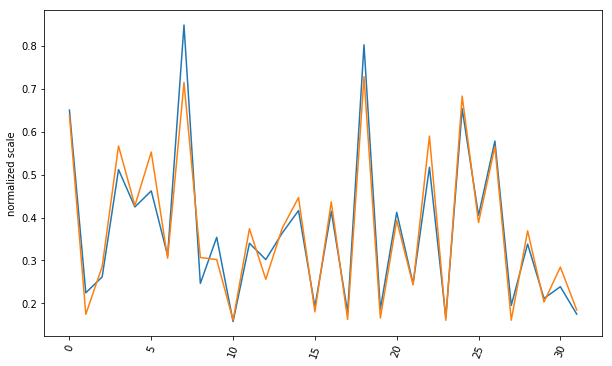

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(Y_test, alpha = 1)
plt.plot(Y_predicted, alpha = 1)

# need to add legend
plt.ylabel('normalized scale')
plt.xticks(rotation=70)
plt.show()

#### commentary:
In the test train split function in scikit learn, the selection of the test data is pulled at random. For example if we have 25% of our data to be considered test data, it would be datapoints pulled from random days, until it comprises or populates about 25% of our original dataset size. This is noted because this is what distinguishes our regression predictor from "forecasting" which can only really be done with time series analysis. So in our testing data, it will be random datapoints for different dates that have a corresponding value for dow jones index, ethereum price data, etc. I want to make the distinction that our testing data does not have a consecutive week of days into the future to be predicted on, we can pnly perform a prediction given values for our features (DJI, price_eth, price_btc) on that day. 

#### EXPLORING FEATURE IMPORTANCES OF THE FOLLOWING SCENARIOS 

## 2) Removing ethereum from features.
#### SO back to the unresolved question to explore:  Lets analyze what happens when we switch up the features
Basically as noted above, it was surprising to me that DJI was considered highly predictive for ethereum data and considered to have absolutley zero contribution in BAT price prediction. So the following experiment was explored.
 what happens to our feature importance when we remove ethereum price as a feature, (of course we wouldn't really have a reason to train a model without ethereum price data, but the exercise sheds light onto how the feature importance changes when you remove one feature)

In [39]:
features_df2 = features_df.copy(deep=True)

In [41]:
features_df2 = features_df2.drop(['price_eth'],axis = 1) #removing ethereum

In [43]:
features_df2.head()

,SearchFrequency,DJI,price_btc,sentiment,pos_count,neg_count,price_bat,count
Date,,,,,,,,
2017-11-16,55,23458.359375,7871.69,0.089579,14,15,0.167167,29
2017-11-17,75,23358.240234,7708.99,0.087821,8,31,0.160654,39
2017-11-18,103,23358.240234,7790.15,0.092867,5,8,0.162501,13
2017-11-19,65,23358.240234,8036.49,0.092423,3,12,0.161358,15
2017-11-20,96,23430.330078,8200.64,0.093611,7,10,0.157709,17


In [44]:
y = np.array(features_df2['price_bat'])
# Remove the labels from the features
# axis 1 refers to the columns
features= features_df2.drop(['price_bat'], axis = 1) #'pos_count','neg_count' 
# Saving feature names for later use
feature_list = list(features.columns) #this way we remeber the column names
# Convert to numpy array
X = np.array(features) #because once we convert to np array it drops the names

In [45]:
#making sure the shapes make sense
print(X.shape)
print(y.shape) #y should be 1 dimensional 

(126, 7)
(126,)


In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [47]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Below we print out our feature importancce values to give us an idea of which feature is the most important to our model. Here we note that any features that go to zero would be considered to not play any role in improving our model. There are two features that are close to zero but still non-zero, so they technically are still marginally improving our model.

In [56]:
feature_names, feature_scores = zip(*sorted(zip(feature_list, feat_import), 
                                                          key=lambda x: -x[1], reverse=True))
featimp_d = {'features': feature_names, 'importances': feature_scores}
featimp_df = pd.DataFrame(data=featimp_d)
featimp_df.set_index('features')

,importances
features,
sentiment,0.000000
pos_count,0.000000
neg_count,0.000000
count,0.009469
SearchFrequency,0.059209
price_btc,0.188028
DJI,0.743294


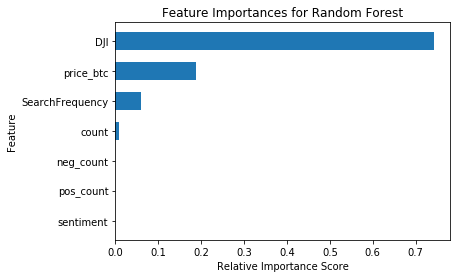

In [48]:
feat_import = regr.feature_importances_
feature_names, feature_scores = zip(*sorted(zip(feature_list, feat_import), 
                                                          key=lambda x: -x[1], reverse=True))
feature_names = feature_names[:10]
feature_scores = feature_scores[:10]
y_position = list(range(len(feature_names)))
plt.barh(y_position, feature_scores, height=0.6, align='center')
plt.yticks(y_position , feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Random Forest')
plt.show()

In [58]:
#now can compare with the original X and Y_train!!!
#using score 
regr.score(X_test, Y_test) #X_test , as seen above...X_test has more dimensions than the output on predict

0.7892377225224031

In [59]:
#use a grid search
param_grid = {"criterion": ["mse", "mae"], 
              # mean squared error and mean absolute error in documentation
              "max_depth": [2, 6, 8],
              "n_estimators":[50, 100, 200]
              #"min_samples_leaf": [20, 40, 100],
              #"max_leaf_nodes": [5, 20, 100, 500, 800],
              }

grid_cv_regr = GridSearchCV(regr, param_grid, cv=5)

grid_cv_regr.fit(X_train, Y_train) #features and labels

/Users/alexandraduboy/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 200], 'criterion': ['mse', 'mae'], 'max_depth': [2, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [60]:
grid_cv_regr.score(X_test, Y_test)

0.8949345698778719

grid search improved it quite a bit.

## 3) Exploring the feature importance that results when we remove 'pos_count' and 'price_etc'

by no you know the drill, commentary is sparse

In [83]:
features_df3 = features_df.copy(deep=True)

In [84]:
features_df3 = features_df3.drop(['price_eth','pos_count'],axis = 1) #removing ethereum

In [85]:
features_df3.head()

,SearchFrequency,DJI,price_btc,sentiment,neg_count,price_bat
Date,,,,,,
2017-11-16,55,23458.359375,7871.69,0.089579,75,0.167167
2017-11-17,75,23358.240234,7708.99,0.087821,59,0.160654
2017-11-18,103,23358.240234,7790.15,0.092867,82,0.162501
2017-11-19,65,23358.240234,8036.49,0.092423,78,0.161358
2017-11-20,96,23430.330078,8200.64,0.093611,80,0.157709


In [86]:
y = np.array(features_df3['price_bat'])
# Remove the labels from the features
# axis 1 refers to the columns
features= features_df3.drop(['price_bat'], axis = 1) #'pos_count','neg_count' 
# Saving feature names for later use
feature_list = list(features.columns) #this way we remeber the column names
# Convert to numpy array
X = np.array(features) #because once we convert to np array it drops the names

In [87]:
#making sure the shapes make sense
print(X.shape)
print(y.shape) #y should be 1 dimensional 

(126, 5)
(126,)


In [88]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [89]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [90]:
feat_import = regr.feature_importances_
feature_names, feature_scores = zip(*sorted(zip(feature_list, feat_import), 
                                                          key=lambda x: -x[1], reverse=True))
featimp_d = {'features': feature_names, 'importances': feature_scores}
featimp_df = pd.DataFrame(data=featimp_d)
featimp_df.set_index('features')

,importances
features,
sentiment,0.000000
neg_count,0.000000
SearchFrequency,0.059209
price_btc,0.188388
DJI,0.752404


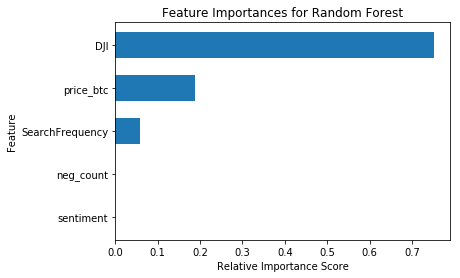

In [91]:
feat_import = regr.feature_importances_
feature_names, feature_scores = zip(*sorted(zip(feature_list, feat_import), 
                                                          key=lambda x: -x[1], reverse=True))
feature_names = feature_names[:10]
feature_scores = feature_scores[:10]
y_position = list(range(len(feature_names)))
plt.barh(y_position, feature_scores, height=0.6, align='center')
plt.yticks(y_position , feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Random Forest')
plt.show()

#### sadly, it looks like 'neg_count' still has no feature importance

In [92]:
regr.score(X_test, Y_test)

0.7905936110655607

In [93]:
#use a grid search
param_grid = {"criterion": ["mse", "mae"], 
              # mean squared error and mean absolute error in documentation
              "max_depth": [2, 6, 8],
              "n_estimators":[50, 100, 200]
              #"min_samples_leaf": [20, 40, 100],
              #"max_leaf_nodes": [5, 20, 100, 500, 800],
              }

grid_cv_regr = GridSearchCV(regr, param_grid, cv=5)

grid_cv_regr.fit(X_train, Y_train) #features and labels

/Users/alexandraduboy/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 200], 'criterion': ['mse', 'mae'], 'max_depth': [2, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [94]:
grid_cv_regr.score(X_test, Y_test)

0.8843707632284217

### Conclusions: 
We were hoping to find some signal in the data scraped from reddit, in correlation to the positive and negative statements made each day (a custom, more crypto-specific measure of public sentiment) unfortunatley we still did not find that there was a strong enough feature importance. We did however recognize that when two variables are highly correlated, one of them will go to zero in feature importance. This can also be explored through the pearson correlation coeffiecient.